- Author: Peter Steiglechner
- Start Date: Jan 2024

> **The core idea**: Using data from the ESS about Germans' climate change opinions in 2016 and in 2020 to estimate subjective actual and perceived opinion polarisation based on social identities. This notebook produces visualisations of the Explorative Data Analysis:
> - histograms (and fitted beta distributions) of the German climate opinions
> - inferred representations of the opinion space




In [1]:
from main import *

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta, norm

sns.set_style("ticks", {"axes.linewidth":0.5})
smallfs = 8
bigfs = 10
plt.rc('font', size=smallfs)          # Ticklabels, legend labels, etc.
plt.rc('axes', labelsize=bigfs)    # Axis labels
plt.rc('axes', titlesize=bigfs)    # Titles

# Load and prepare Data

In [2]:
folder = "inputdata/"

# Load data
cntry = "DE"
variables = ["ccnthum", "wrclmch"]
variables_na = {"ccnthum": [55, 66, 77, 88, 99], "wrclmch": [6, 7, 8, 9]} 
waves = [8, 10]

# Define German parties
wave_t0_prtcl = "prtclede"
wave_t1_prtcl = "prtclfde"

ESSparty_dict_t0 = {
    1: "Union",
    2: "SPD",
    3: "Left Party",
    4: "Greens", 
    5: "FDP",
    6: "AfD"
}
for p in [7,8,9]: # coded "other Party" as np.nan
    ESSparty_dict_t0[p] = -1
ESSparty_dict_t1 = ESSparty_dict_t0
for p in [7,8,9]: # coded "other Party" as np.nan
    ESSparty_dict_t1[p] = -1
for p in [66,88]: # coded as separate "None" fraction 
    ESSparty_dict_t0[p] = "None"
    ESSparty_dict_t1[p] = "None"

parties = ["Left Party", "Greens", "SPD", "None", "FDP", "Union", "AfD"]
assert all([((p in ESSparty_dict_t0.values()) and (p in ESSparty_dict_t1.values())) for p in parties])


cols = ["essround", "anweight", "cntry", "prtdgcl"] + variables
rawdataC = pd.concat(
        [
            pd.read_csv(f"{folder}{essfile}.csv", 
                        usecols=cols + [prtclcol]) 
            for essfile, prtclcol in zip(["ESS8e02_3", "ESS10SC"], [wave_t0_prtcl, wave_t1_prtcl])
        ], 
        axis=0
    )
data = rawdataC.loc[rawdataC.cntry == cntry]
data = data.reset_index()


# Run analysis

data = prepareData(data, wave_t0_prtcl, wave_t1_prtcl, ESSparty_dict_t0, ESSparty_dict_t1, variables=variables, variables_na=variables_na)
filtered_data = data.dropna(subset=["identity"]+variables, how="any", axis="index")


In [3]:
cols = dict(zip(["Union", "SPD", "Left Party", "Greens", "FDP", "AfD", "None"], ["#000000", "#E3000F", "#b61c3e", "#1AA037", "#FFEF00", "#0489DB", "grey"]))  # 

kuerzel2party = {"u":"Union", "s":"SPD", "l":"Left Party", "g":"Greens", "f":"FDP", "a":"AfD", "n":"None"}


# Plot Distributions without identities

In [4]:
questionLong = {
    "ccnthum":"Do you think climate change is caused by natural processes, human activity, or both?", 
    "wrclmch":"How worried are you about climate change?"
    }
question = {
    "ccnthum":"Climate change caused by natural \nprocesses, human activity, or both?", 
    "wrclmch":"How worried about\nclimate change?"
    }
replies = {
    "ccnthum": dict(zip(range(1,6), ["Entirely by natural processes", "Mainly by natural processes", "About equally by natural processes and human activity", "Mainly by human activity", "Entirely by human activity"])), 
    "wrclmch":dict(zip(range(1,6), ["Not at all worried", "Not very worried", "Somewhat worried", "Very worried", "Extremely worried"]))    
    # 55	I don't think climate change is happening 
}

repliesShort = {
    "ccnthum": dict(zip(range(1,6), ["natural", "mainly natural", "both", "mainly human", "human"])), 
    "wrclmch":dict(zip(range(1,6), ["not at all", "not very", "somewhat", "Very", "extremely"]))    
    # 55	I don't think climate change is happening 
}

### WRCLMCH data all & by-party 

8 Beta Fit {'mean': '3.352', 'var': '0.762', 'skew': '-0.178', 'kurt': '-0.555'}
8 Gauss Fit {'mean': '3.356', 'var': '0.723', 'skew': '0.000', 'kurt': '0.000'}
10 Beta Fit {'mean': '3.604', 'var': '0.824', 'skew': '-0.327', 'kurt': '-0.513'}
10 Gauss Fit {'mean': '3.614', 'var': '0.797', 'skew': '0.000', 'kurt': '0.000'}


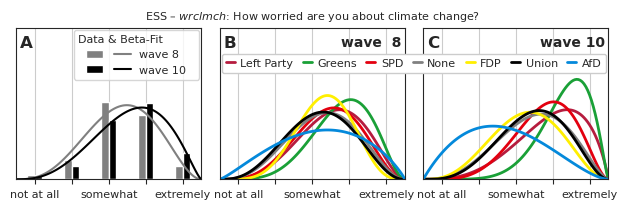

In [5]:

fig, axs = plt.subplots(1,3, sharey=False, figsize=(16/2.54, 5/2.54), gridspec_kw={"wspace":0.1})
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = ["grey", "k"] #prop_cycle.by_key()['color']
var = "wrclmch"
x = np.linspace(0.5,5.5,100)
for n, r in enumerate(waves):
    props = beta.fit(filtered_data.loc[filtered_data.essround==r][var].dropna(), floc=x[0], fscale=x[-1]-x[0])
    propsN = norm.fit(filtered_data.loc[filtered_data.essround==r][var].dropna())
    fitted_beta = beta(*props)
    fitted_norm = norm(*propsN)
    fitstats = fitted_beta.stats(moments='mvsk')
    print(r, "Beta Fit", dict(zip(["mean", "var", "skew", "kurt"], [f"{f:.3f}" for f in fitstats])))
    print(r, "Gauss Fit", dict(zip(["mean", "var", "skew", "kurt"], [f"{f:.3f}" for f in fitted_norm.stats(moments="mvsk")])))
    bins=np.arange(0.5, 5.51)
    vals, bins = np.histogram(filtered_data.loc[filtered_data.essround==r][var], density=True, bins=bins)
    xbar = bins[:-1]+0.5 + (-0.1 if r==8 else 0.1)
    axs[0].bar(xbar, vals, alpha=1, width=0.2, label=f"wave {r}",  color=colors[n])
    axs[0].plot(x, fitted_beta.pdf(x), label=f"wave {r}", color=colors[n])
    #ax.plot(x, fitted_norm.pdf(x), ls="--", color=colors[n])

h, l = axs[0].get_legend_handles_labels()
ph = [plt.plot([],marker="", ls="")[0]]
handles = [h[2], h[3], h[0], h[1]]
labels =["", ""] + [l[2]] + [l[3]]
axs[0].legend(handles, labels, fontsize=smallfs, ncol=2, handlelength=1.5, handletextpad=0.8, columnspacing=0.2, title="Data & Beta-Fit         ", bbox_to_anchor=(0.99, 0.99), loc="upper right",borderaxespad=0.04)
#axs[1].legend(handles, labels, fontsize=smallfs, ncol=2, handletextpad=1.3, columnspacing=0.6, title="Data & Beta-Fit                  ", bbox_to_anchor=(1.02, 1.05))
#plt.legend(handles, labels, ncol=2)
plt.setp(axs[0].get_legend().get_title(), fontsize=smallfs) # for legend title

fitted_betas_xparty = {}

x = np.linspace(0.5,5.5,100)
fitted_betas_xparty = {8:{}, 10:{}}
for n, (ax, r) in enumerate(zip(axs[1:], waves)):
    for party in parties:
        props = beta.fit(filtered_data.loc[filtered_data.identity==party].loc[filtered_data.essround==r][var].dropna(), floc=x[0], fscale=x[-1]-x[0])
        fitted_beta = beta(*props)
        fitted_betas_xparty[int(r)][party] = fitted_beta
        fitstats = fitted_beta.stats(moments='mvsk')

        #if party=="Green":
        #    filtered_data.loc[filtered_data.identity==4].loc[filtered_data.essround==r][var].plot.hist(color=cols["Green"], bins=np.arange(-0.5, 5.51), width=0.8, density=True, label=party, alpha=0.2, ax=ax)

        ax.plot(x, fitted_beta.pdf(x), color=cols[party], label=party, lw=2)
axs[2].legend(loc="upper right", bbox_to_anchor=(0.99, 0.83), ncol=7, fontsize=smallfs, handlelength=0.8, handletextpad=0.5, columnspacing=0.85,borderaxespad=0.04, framealpha=1)



axs[1].set_title(fr"ESS – ${var}$: {questionLong[var]}", fontsize=smallfs) 
for ax in axs:
    ax.set_facecolor('white')
    #ax.set_xlabel(question[var],  fontsize=smallfs) #  + f"\n–{var}–",
    ax.set_xlim(x[0], x[-1])
    ax.set_xticks(np.arange(x[0]+0.5, x[-1]))
    ax.set_xticklabels([repliesShort[var][k] if k%2==1 else "" for k in ax.get_xticks() ], fontsize=smallfs)
    ax.set_ylabel("", fontsize=bigfs, y=0)
    ax.set_yticklabels([])
    ax.tick_params(left=False, bottom=True)
    ax.grid(axis="x", zorder=0)
axs[0].set_ylim(0,0.85)
axs[1].set_ylim(0,0.95)
axs[2].set_ylim(0,0.95)
axs[1].text(0.98, 0.95, "wave  8", va="top", ha="right", fontdict={"weight":"bold", "size":bigfs}, transform=axs[1].transAxes)
axs[2].text(0.98, 0.95, "wave 10", va="top", ha="right", fontdict={"weight":"bold", "size":bigfs}, transform=axs[2].transAxes)
axs[0].text(0.02, 0.95, "A", va="top", ha="left", fontdict={"weight":"bold", "size":12}, transform=axs[0].transAxes)
axs[1].text(0.02, 0.95, "B", va="top", ha="left", fontdict={"weight":"bold", "size":12}, transform=axs[1].transAxes)
axs[2].text(0.02, 0.95, "C", va="top", ha="left", fontdict={"weight":"bold", "size":12}, transform=axs[2].transAxes)

#fig.set_facecolor("yellow")
fig.subplots_adjust(bottom=0.12, left=0.03, right=0.97, top=0.89)
plt.savefig("figs/wrclmch_ESS8-10_3panels.pdf")
plt.savefig("figs/wrclmch_ESS8-10_3panels.png", dpi=600)

8 Beta Fit {'mean': '3.352', 'var': '0.762', 'skew': '-0.178', 'kurt': '-0.555'}
8 Gauss Fit {'mean': '3.356', 'var': '0.723', 'skew': '0.000', 'kurt': '0.000'}
10 Beta Fit {'mean': '3.604', 'var': '0.824', 'skew': '-0.327', 'kurt': '-0.513'}
10 Gauss Fit {'mean': '3.614', 'var': '0.797', 'skew': '0.000', 'kurt': '0.000'}


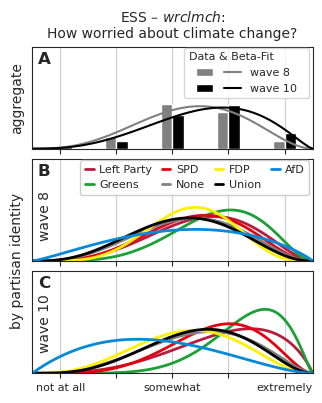

In [6]:

fig, axs = plt.subplots(3,1, sharex=True, figsize=(8/2.54, 10/2.54), gridspec_kw={"hspace":0.1})
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = ["grey", "k"] #prop_cycle.by_key()['color']
var = "wrclmch"
x = np.linspace(0.5,5.5,100)
for n, r in enumerate(waves):
    props = beta.fit(filtered_data.loc[filtered_data.essround==r][var].dropna(), floc=x[0], fscale=x[-1]-x[0])
    propsN = norm.fit(filtered_data.loc[filtered_data.essround==r][var].dropna())
    fitted_beta = beta(*props)
    fitted_norm = norm(*propsN)
    fitstats = fitted_beta.stats(moments='mvsk')
    print(r, "Beta Fit", dict(zip(["mean", "var", "skew", "kurt"], [f"{f:.3f}" for f in fitstats])))
    print(r, "Gauss Fit", dict(zip(["mean", "var", "skew", "kurt"], [f"{f:.3f}" for f in fitted_norm.stats(moments="mvsk")])))
    bins=np.arange(0.5, 5.51)
    vals, bins = np.histogram(filtered_data.loc[filtered_data.essround==r][var], density=True, bins=bins)
    xbar = bins[:-1]+0.5 + (-0.1 if r==8 else 0.1)
    axs[0].bar(xbar, vals, alpha=1, width=0.2, label=f"wave {r}",  color=colors[n])
    axs[0].plot(x, fitted_beta.pdf(x), label=f"wave {r}", color=colors[n])
    #ax.plot(x, fitted_norm.pdf(x), ls="--", color=colors[n])

h, l = axs[0].get_legend_handles_labels()
ph = [plt.plot([],marker="", ls="")[0]]
handles = [h[2], h[3], h[0], h[1]]
labels =["", ""] + [l[2]] + [l[3]]
axs[0].legend(handles, labels, fontsize=smallfs, ncol=2, handlelength=1.5, handletextpad=0.8, columnspacing=0.2, title="Data & Beta-Fit         ", bbox_to_anchor=(0.99, 0.99), loc="upper right",borderaxespad=0.04)
#axs[1].legend(handles, labels, fontsize=smallfs, ncol=2, handletextpad=1.3, columnspacing=0.6, title="Data & Beta-Fit                  ", bbox_to_anchor=(1.02, 1.05))
#plt.legend(handles, labels, ncol=2)
plt.setp(axs[0].get_legend().get_title(), fontsize=smallfs) # for legend title

fitted_betas_xparty = {}

x = np.linspace(0.5,5.5,100)
fitted_betas_xparty = {8:{}, 10:{}}
for n, (ax, r) in enumerate(zip(axs[1:], waves)):
    for party in parties:
        props = beta.fit(filtered_data.loc[filtered_data.identity==party].loc[filtered_data.essround==r][var].dropna(), floc=x[0], fscale=x[-1]-x[0])
        fitted_beta = beta(*props)
        fitted_betas_xparty[int(r)][party] = fitted_beta
        fitstats = fitted_beta.stats(moments='mvsk')

        #if party=="Green":
        #    filtered_data.loc[filtered_data.identity==4].loc[filtered_data.essround==r][var].plot.hist(color=cols["Green"], bins=np.arange(-0.5, 5.51), width=0.8, density=True, label=party, alpha=0.2, ax=ax)

        ax.plot(x, fitted_beta.pdf(x), color=cols[party], label=party, lw=2)
axs[1].legend(loc="upper right", bbox_to_anchor=(0.99, 0.99), ncol=4, fontsize=smallfs, handlelength=0.8, handletextpad=0.5, columnspacing=0.85,borderaxespad=0.04, framealpha=1)


question["wrclmch"] = "How worried about climate change?"
axs[0].set_title(fr"ESS – ${var}$:"+"\n"+f"{question[var]}", fontsize=bigfs) 
for ax in axs:
    ax.set_facecolor('white')
    #ax.set_xlabel(question[var],  fontsize=smallfs) #  + f"\n–{var}–",
    ax.set_xlim(x[0], x[-1])
    ax.set_xticks(np.arange(x[0]+0.5, x[-1]))
    ax.set_xticklabels([repliesShort[var][k] if k%2==1 else "" for k in ax.get_xticks() ], fontsize=smallfs)
    ax.set_ylabel("", fontsize=bigfs, y=0)
    ax.set_yticklabels([])
    ax.tick_params(left=False, bottom=True)
    ax.grid(axis="x", zorder=0)
axs[0].set_ylim(0,1.)
axs[1].set_ylim(0,1.)
axs[2].set_ylim(0,1)
axs[0].text(0.02, 0.95, "A", va="top", ha="left", fontdict={"weight":"bold", "size":12}, transform=axs[0].transAxes)
axs[1].text(0.02, 0.95, "B", va="top", ha="left", fontdict={"weight":"bold", "size":12}, transform=axs[1].transAxes)
axs[2].text(0.02, 0.95, "C", va="top", ha="left", fontdict={"weight":"bold", "size":12}, transform=axs[2].transAxes)

axs[0].set_ylabel("aggregate", fontsize=bigfs, fontdict={"weight":"normal"},x=-0.03, y=0.5,  va="center",  ha="center")
axs[1].set_ylabel("by partisan identity", fontsize=bigfs, fontdict={"weight":"normal"}, y=0, x=-0.03, va="center", ha="center")
axs[1].text(0.02,0.2, "wave 8", fontsize=bigfs, transform=axs[1].transAxes, fontdict={"weight":"normal"},va="bottom", ha="left", rotation=90)
axs[2].text(0.02,0.2, "wave 10", fontsize=bigfs,transform=axs[2].transAxes, fontdict={"weight":"normal"},va="bottom", ha="left", rotation=90)

#fig.set_facecolor("yellow")
fig.subplots_adjust(bottom=0.07, left=0.08, right=0.97, top=0.9)
plt.savefig("figs/wrclmch_ESS8-10_3panelsVert.pdf")
plt.savefig("figs/wrclmch_ESS8-10_3panelsVert.png", dpi=600)

### wrclmch and ccnthum, all individuals

ccnthum
8 Beta Fit {'mean': '3.515', 'var': '0.525', 'skew': '-0.229', 'kurt': '-0.375'}
8 Gauss Fit {'mean': '3.521', 'var': '0.495', 'skew': '0.000', 'kurt': '0.000'}
10 Beta Fit {'mean': '3.703', 'var': '0.553', 'skew': '-0.332', 'kurt': '-0.332'}
10 Gauss Fit {'mean': '3.709', 'var': '0.526', 'skew': '0.000', 'kurt': '0.000'}
wrclmch
8 Beta Fit {'mean': '3.352', 'var': '0.762', 'skew': '-0.178', 'kurt': '-0.555'}
8 Gauss Fit {'mean': '3.356', 'var': '0.723', 'skew': '0.000', 'kurt': '0.000'}
10 Beta Fit {'mean': '3.604', 'var': '0.824', 'skew': '-0.327', 'kurt': '-0.513'}
10 Gauss Fit {'mean': '3.614', 'var': '0.797', 'skew': '0.000', 'kurt': '0.000'}


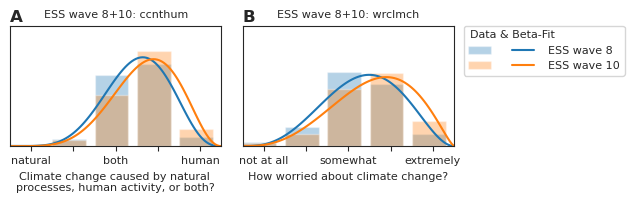

In [7]:

fig, axs = plt.subplots(1,2, sharey=True, figsize=(16/2.54, 5/2.54), gridspec_kw={"wspace":0.1})
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for ax, var in zip(axs, ["ccnthum", "wrclmch"]):
    print(var)
    x = np.linspace(0.5,5.5,100)
    for n, r in enumerate(waves):
        props = beta.fit(filtered_data.loc[filtered_data.essround==r][var].dropna(), floc=x[0], fscale=x[-1]-x[0])
        propsN = norm.fit(filtered_data.loc[filtered_data.essround==r][var].dropna())
        fitted_beta = beta(*props)
        fitted_norm = norm(*propsN)
        fitstats = fitted_beta.stats(moments='mvsk')
        print(r, "Beta Fit", dict(zip(["mean", "var", "skew", "kurt"], [f"{f:.3f}" for f in fitstats])))
        print(r, "Gauss Fit", dict(zip(["mean", "var", "skew", "kurt"], [f"{f:.3f}" for f in fitted_norm.stats(moments="mvsk")])))
        p = filtered_data.loc[filtered_data.essround==r][var].plot.hist(ax=ax, alpha=0.33, bins=np.arange(-0.5, 5.51), width=0.8, density=True, label=f"ESS wave {r}")
        ax.plot(x, fitted_beta.pdf(x), label=f"ESS wave {r}", color=colors[n])
        #ax.plot(x, fitted_norm.pdf(x), ls="--", color=colors[n])
        ax.set_facecolor('white')
    ax.set_xlabel(question[var],  fontsize=smallfs) #  + f"\n–{var}–",
    ax.set_ylim(0,0.7)
    ax.set_xlim(x[0], x[-1])
    ax.set_xticks(np.arange(x[0]+0.5, x[-1]))
    ax.set_xticklabels([repliesShort[var][k] if k%2==1 else "" for k in ax.get_xticks() ], fontsize=smallfs)

axs[0].set_ylabel("", fontsize=bigfs, y=0)
h, l = axs[1].get_legend_handles_labels()
ph = [plt.plot([],marker="", ls="")[0]]
handles = [h[0]] + [h[2]] + [h[1]] + [h[3]]
labels =["", ""] + [l[1]] + [l[3]]
axs[1].legend(handles, labels, fontsize=smallfs, ncol=2, handletextpad=1.3, columnspacing=0.6, title="Data & Beta-Fit                  ", bbox_to_anchor=(1.02, 1.05))
#axs[1].legend(handles, labels, fontsize=smallfs, ncol=2, handletextpad=1.3, columnspacing=0.6, title="Data & Beta-Fit                  ", bbox_to_anchor=(1.02, 1.05))
#plt.legend(handles, labels, ncol=2)
plt.setp(axs[1].get_legend().get_title(), fontsize=smallfs) # for legend title

axs[0].set_title(fr"ESS wave 8+10: {variables[0]}", fontsize=smallfs, y=1)
axs[1].set_title(fr"ESS wave 8+10: {variables[1]}", fontsize=smallfs, y=1)

axs[0].text(0.00, 1.01, "A", va="bottom", ha="left", fontdict={"weight":"bold", "size":12}, transform=axs[0].transAxes)
axs[1].text(0.0, 1.01, "B", va="bottom", ha="left", fontdict={"weight":"bold", "size":12}, transform=axs[1].transAxes)
for ax in axs:
    ax.set_yticklabels([])
    ax.tick_params(left=False, bottom=True)
#fig.set_facecolor("yellow")
fig.subplots_adjust(bottom=0.28, left=0.015, right=0.72, top=0.89)
plt.savefig("figs/clchvars_total-distribution_wave8-10.pdf")
plt.savefig("figs/clchvars_total-distribution_wave8-10.png", dpi=600)

### Plot distributions by identities

ccnthum
wrclmch


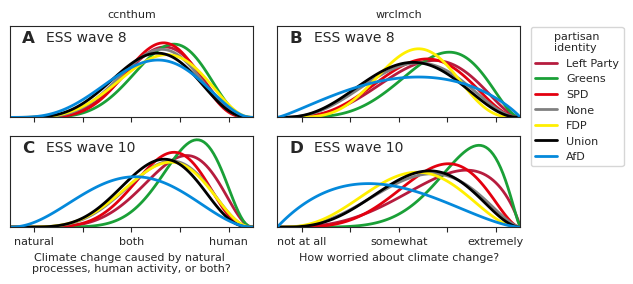

In [8]:
fig, axs = plt.subplots(2,2, sharey=True, figsize=(16/2.54, 7/2.54), sharex="col", gridspec_kw={"wspace":0.1})
#prop_cycle = plt.rcParams['axes.prop_cycle']
#colors = prop_cycle.by_key()['color']
fitted_betas_xparty = {}
for axcol, var in zip([axs[:,0], axs[:,1]], ["ccnthum", "wrclmch"]):
    print(var)
    #axcol[0].set_title(var)
    x = np.linspace(0.5,5.5,100)
    fitted_betas_xparty[var] = {8:{}, 10:{}}
    for n, (ax, r) in enumerate(zip(axcol, waves)):
        for party in parties:
            props = beta.fit(filtered_data.loc[filtered_data.identity==party].loc[filtered_data.essround==r][var].dropna(), floc=x[0], fscale=x[-1]-x[0])
            fitted_beta = beta(*props)
            fitted_betas_xparty[var][int(r)][party] = fitted_beta
            fitstats = fitted_beta.stats(moments='mvsk')

            #if party=="Green":
            #    filtered_data.loc[filtered_data.identity==4].loc[filtered_data.essround==r][var].plot.hist(color=cols["Green"], bins=np.arange(-0.5, 5.51), width=0.8, density=True, label=party, alpha=0.2, ax=ax)

            ax.plot(x, fitted_beta.pdf(x), color=cols[party], label=party, lw=2)
        ax.set_facecolor('white')
        ax.set_yticks([])
        ax.tick_params(left=False, bottom=True)

    ax.set_xlabel(question[var], fontsize=smallfs)#+ f"\n–{var}–", fontsize=smallfs)
    ax.set_xlim(x[0], x[-1])
    ax.set_xticks(np.arange(x[0]+0.5, x[-1]))
    ax.set_xticklabels([repliesShort[var][k] if k%2==1 else "" for k in ax.get_xticks() ], fontsize=smallfs)

axs[0,0].set_title(fr"{variables[0]}", fontsize=smallfs)
axs[0,1].set_title(fr"{variables[1]}", fontsize=smallfs)
axs[0,1].legend(bbox_to_anchor=(1.02, 1.05), fontsize=smallfs, title="partisan\nidentity")


#axs[0,0].set_ylabel("Frequency", fontsize=bigfs, y=0)
axs[0,0].text(0.15,0.95, "ESS wave 8", ha="left", va="top", transform=axs[0,0].transAxes, fontsize=bigfs)
axs[1,0].text(0.15,0.95, "ESS wave 10", ha="left", va="top", transform=axs[1,0].transAxes, fontsize=bigfs)
axs[0,1].text(0.15,0.95, "ESS wave 8", ha="left", va="top", transform=axs[0,1].transAxes, fontsize=bigfs)
axs[1,1].text(0.15,0.95, "ESS wave 10", ha="left", va="top", transform=axs[1,1].transAxes, fontsize=bigfs)

#axs[0,0].legend(fontsize=8, ncol=2)
axs[0,0].set_ylim(0,0.7)

fig.subplots_adjust(bottom=0.19, left=0.02, right=0.83, top=0.92)
#fig.set_facecolor("y")

axs[0,0].text(0.05, 0.95, "A", va="top", ha="left", fontdict={"weight":"bold", "size":12}, transform=axs[0, 0].transAxes)
axs[0, 1].text(0.05, 0.95, "B", va="top", ha="left", fontdict={"weight":"bold", "size":12}, transform=axs[0,1].transAxes)
axs[1, 0].text(0.05, 0.95, "C", va="top", ha="left", fontdict={"weight":"bold", "size":12}, transform=axs[1,0].transAxes)
axs[1, 1].text(0.05, 0.95, "D", va="top", ha="left", fontdict={"weight":"bold", "size":12}, transform=axs[1,1].transAxes)

plt.savefig("figs/clchvars_party-distribution_wave8-10.pdf")
plt.savefig("figs/clchvars_party-distribution_wave8-10.png", dpi=600)

# 2D climate opinion space

In [7]:
CSS_dict, Trafo = get_Trafo(filtered_data, parties, waves=[8,10], variables=variables)

## Without identities

In [8]:
import matplotlib.colors as colors 
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


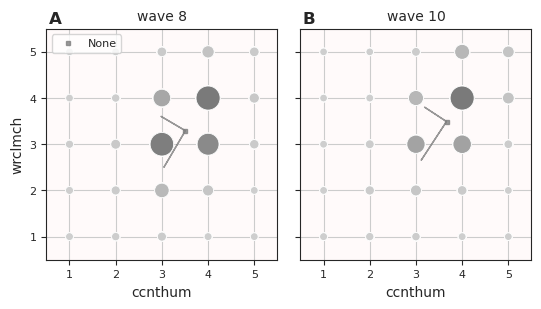

In [9]:
scale = 1
cmap = truncate_colormap(plt.get_cmap("Greys"), 0.3, 0.6)
fig, axs = plt.subplots(1,2, sharex=True, sharey=True, figsize=(16/2.54,8/2.54))#figsize=(16/2.54,8/2.54))
for r, ax in zip(waves, axs):
    ax.set_facecolor("snow")
    df =  filtered_data.loc[filtered_data.essround==r][["ccnthum", "wrclmch"]].dropna(how="any")
    counts = df.groupby(['wrclmch', 'ccnthum']).size()
    df['observation_count'] = df.groupby(['wrclmch', 'ccnthum']).transform('size')
    sns.scatterplot(
        x='ccnthum',
        y='wrclmch',
        hue='observation_count',
        palette=cmap,  # Blues and oranges color palette
        size='observation_count',
        sizes=(30, 300),  # Adjust size range
        data=df,
        ax = ax, 
        legend=False
    )
    for p in parties:
        if not p=="None":
            pass
        else:
            col = cols[p]      
            
            X_train = filtered_data.loc[filtered_data.essround==r].loc[filtered_data.identity==p][["ccnthum", "wrclmch"]].dropna(how="any").to_numpy()
            ax.plot(X_train[:,0].mean(), X_train[:,1].mean(), color=col, ls="", marker="s", markersize=3 , alpha=0.8, label=p)
            for i in range(2):
                vec = CSS_dict[r][p][:, i] * scale
                if (r==waves[0]) and (i==0) and (p=="FDP"):
                    vec=-vec
                dx = vec[0] 
                dy = vec[1] 
                ax.arrow(X_train[:,0].mean(), X_train[:,1].mean(), dx, dy,color=cols[p], lw=1, alpha=0.8)
            ax.set_ylim(0.5, 5.5)
            ax.set_xlim(0.5, 5.5)
            ax.set_xticks(range(1,6))
            ax.set_yticks(range(1,6))
            ax.set_aspect("equal")
            ax.grid(True)
            ax.set_xlabel("ccnthum", fontsize=bigfs)
            if r==waves[0]:
                ax.set_ylabel("wrclmch", fontsize=bigfs)
            ax.set_title(f"wave {r}", fontsize=bigfs)
axs[0].legend(fontsize=smallfs)
fig.subplots_adjust(left=0.13, right=0.9, top=0.96, wspace=0.1)


axs[0].text(0.01, 1.01, "A", va="bottom", ha="left", fontdict={"weight":"bold", "size":12}, transform=axs[0].transAxes)
axs[1].text(0.01, 1.01, "B", va="bottom", ha="left", fontdict={"weight":"bold", "size":12}, transform=axs[1].transAxes)

#fig.set_facecolor("y")

#plt.savefig("figs/Trafo_8-10_clch_party_onlyBlobsTot.png", dpi=600)
plt.savefig(f"figs/Trafo_{waves[0]}-{waves[1]}_clch_party_+density_withoutId.png", dpi=600)
plt.savefig(f"figs/Trafo_{waves[0]}-{waves[1]}_clch_party_+density_withoutId.pdf")
    

## With identities

### with density

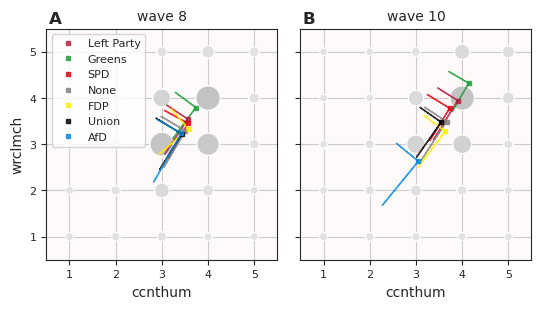

In [10]:
scale = 1

cmap = truncate_colormap(plt.get_cmap("Greys"), 0.2, 0.35)
fig, axs = plt.subplots(1,2, sharex=True, sharey=True, figsize=(16/2.54,8/2.54))#figsize=(16/2.54,8/2.54))
for r, ax in zip(waves, axs):
    ax.set_facecolor("snow")
    df =  filtered_data.loc[filtered_data.essround==r][["ccnthum", "wrclmch"]].dropna(how="any")
    counts = df.groupby(['wrclmch', 'ccnthum']).size()
    df['observation_count'] = df.groupby(['wrclmch', 'ccnthum']).transform('size')
    sns.scatterplot(
        x='ccnthum',
        y='wrclmch',
        hue='observation_count',
        palette=cmap,  # Blues and oranges color palette
        size='observation_count',
        sizes=(30, 300),  # Adjust size range
        data=df,
        ax = ax, 
        legend=False
    )
    for p in parties:
        #if not p=="None":
        #    pass
        #else:
        col = cols[p]      
        
        X_train = filtered_data.loc[filtered_data.essround==r].loc[filtered_data.identity==p][["ccnthum", "wrclmch"]].dropna(how="any").to_numpy()
        ax.plot(X_train[:,0].mean(), X_train[:,1].mean(), color=col, ls="", marker="s", markersize=3 , alpha=0.8, label=p)
        for i in range(2):
            vec = CSS_dict[r][p][:, i] * scale
            if (r==waves[0]) and (i==0) and (p=="FDP"):
                vec=-vec
            dx = vec[0] 
            dy = vec[1] 
            ax.arrow(X_train[:,0].mean(), X_train[:,1].mean(), dx, dy,color=cols[p], lw=1, alpha=0.8)
    ax.set_ylim(0.5, 5.5)
    ax.set_xlim(0.5, 5.5)
    ax.set_xticks(range(1,6))
    ax.set_yticks(range(1,6))
    ax.set_aspect("equal")
    ax.grid(True)
    ax.set_xlabel("ccnthum", fontsize=bigfs)
    if r==waves[0]:
        ax.set_ylabel("wrclmch", fontsize=bigfs)
    ax.set_title(f"wave {r}", fontsize=bigfs)
axs[0].legend(fontsize=smallfs)
fig.subplots_adjust(left=0.13, right=0.9, top=0.96, wspace=0.1)


axs[0].text(0.01, 1.01, "A", va="bottom", ha="left", fontdict={"weight":"bold", "size":12}, transform=axs[0].transAxes)
axs[1].text(0.01, 1.01, "B", va="bottom", ha="left", fontdict={"weight":"bold", "size":12}, transform=axs[1].transAxes)

#fig.set_facecolor("y")

#plt.savefig("figs/Trafo_8-10_clch_party_onlyBlobsTot.png", dpi=600)
plt.savefig(f"figs/Trafo_{waves[0]}-{waves[1]}_clch_party_+density_withId.png", dpi=600)
plt.savefig(f"figs/Trafo_{waves[0]}-{waves[1]}_clch_party_+density_withId.pdf")
    

### in separate panels

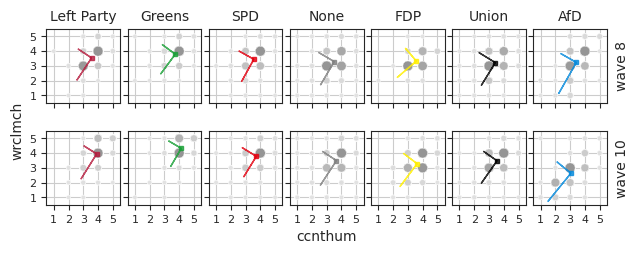

In [11]:

cmap = truncate_colormap(plt.get_cmap("Greys"), 0.2, 0.5)
scale = 2
fig, axs = plt.subplots(2,7, sharex=True, sharey=True, figsize=(16/2.54,6.5/2.54))#figsize=(16/2.54,8/2.54))
for r, row in zip(waves, [0,1]):
    axA = axs[row,:]
    for p, ax in zip(parties, axA):
        ax.set_facecolor("white")
        
        df =  filtered_data.loc[filtered_data.essround==r].loc[filtered_data.identity==p][["ccnthum", "wrclmch"]].dropna(how="any")
        counts = df.groupby(['wrclmch', 'ccnthum']).size()
        df['observation_count'] = df.groupby(['wrclmch', 'ccnthum']).transform('size')
        sns.scatterplot(
            x='ccnthum',
            y='wrclmch',
            hue='observation_count',
            palette=cmap,  # Blues and oranges color palette
            size='observation_count',
            sizes=(10, 50),  # Adjust size range
            data=df,
            alpha=1, 
            ax = ax, 
            legend=False
        )
        
        col = cols[p]
        X_train = filtered_data.loc[filtered_data.essround==r].loc[filtered_data.identity==p][["ccnthum", "wrclmch"]].dropna(how="any").to_numpy()
        ax.plot(X_train[:,0].mean(), X_train[:,1].mean(), color=col, ls="", marker="s", markersize=3 , alpha=0.8, label=p)
        for i in range(2):
            vec = CSS_dict[r][p][:, i] * scale
            if (r==waves[0]) and (i==0) and (p=="FDP"):
                vec=-vec
            dx = vec[0] 
            dy = vec[1] 
            ax.arrow(X_train[:,0].mean(), X_train[:,1].mean(), dx, dy,color=cols[p], lw=1, alpha=0.8)
        ax.set_ylim(0.5, 5.5)
        ax.set_xlim(0.5, 5.5)
        ax.set_xticks(range(1,6))
        ax.set_yticks(range(1,6))
        ax.set_aspect("equal")
        ax.grid(True)
        #if r==waves[0]:
        #    ax.set_ylabel("wrclmch", fontsize=bigfs)
        #ax.set_title(f"ESS wave {r}", fontsize=bigfs)
        if r==waves[0]:
            ax.set_title(f"{p}", fontsize=bigfs)
        
        ax.set_xlabel("")
        ax.set_ylabel("")
axs[1, 3].set_xlabel("ccnthum", fontsize=bigfs)
axs[1, 0].set_ylabel("wrclmch", fontsize=bigfs, y=1)


#axs[0, 0].legend(fontsize=smallfs)
axs[0,-1].text(1.2, 0.5, f"wave {waves[0]}", transform=axs[0,-1].transAxes, va="center", ha="center", rotation=90, fontsize=bigfs)
axs[1,-1].text(1.2, 0.5, f"wave {waves[1]}", transform=axs[1,-1].transAxes, va="center", ha="center", rotation=90, fontsize=bigfs)

fig.subplots_adjust(left=0.06, right=0.95, top=0.88, bottom=0.15, wspace=0.1, )
#fig.tight_layout()

#axs[0].text(0.01, 1.01, "A", va="bottom", ha="left", fontdict={"weight":"bold", "size":12}, transform=axs[0].transAxes)
#axs[1, ].text(0.01, 1.01, "B", va="bottom", ha="left", fontdict={"weight":"bold", "size":12}, transform=axs[1].transAxes)

#fig.set_facecolor("y")

plt.savefig(f"figs/Trafo_{waves[0]}-{waves[1]}_clch_party_party-by-party.png", dpi=600)
plt.savefig(f"figs/Trafo_{waves[0]}-{waves[1]}_clch_party_party-by-party.pdf")
    

### without density

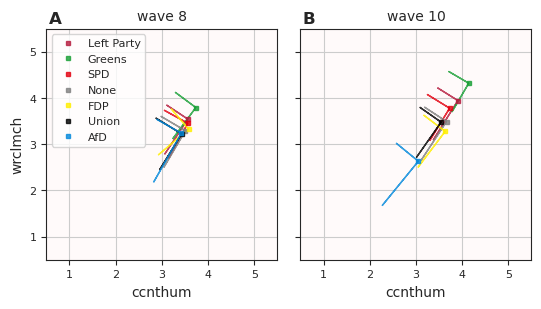

In [12]:
# VIS plot axes of wave 8 and 10 by party
scale = 1
fig, axs = plt.subplots(1,2, sharex=True, sharey=True, figsize=(16/2.54,8/2.54))#figsize=(16/2.54,8/2.54))
for r, ax in zip(waves, axs):
    ax.set_facecolor("snow")
    for p in parties:
        col = cols[p]
        X_train = filtered_data.loc[filtered_data.essround==r].loc[filtered_data.identity==p][["ccnthum", "wrclmch"]].dropna(how="any").to_numpy()
        ax.plot(X_train[:,0].mean(), X_train[:,1].mean(), color=col, ls="", marker="s", markersize=3 , alpha=0.8, label=p)
        for i in range(2):
            vec = CSS_dict[r][p][:, i] * scale
            if (r==waves[0]) and (i==0) and (p=="FDP"):
                vec=-vec
            dx = vec[0] 
            dy = vec[1] 
            ax.arrow(X_train[:,0].mean(), X_train[:,1].mean(), dx, dy,color=cols[p], lw=1, alpha=0.8)
        ax.set_ylim(0.5, 5.5)
        ax.set_xlim(0.5, 5.5)
        ax.set_xticks(range(1,6))
        ax.set_yticks(range(1,6))
        ax.set_aspect("equal")
        ax.grid(True)
        ax.set_xlabel("ccnthum", fontsize=bigfs)
        if r==waves[0]:
            ax.set_ylabel("wrclmch", fontsize=bigfs)
        ax.set_title(f"wave {r}", fontsize=bigfs)
axs[0].legend(fontsize=smallfs)
fig.subplots_adjust(left=0.13, right=0.9, top=0.96, wspace=0.1)


axs[0].text(0.01, 1.01, "A", va="bottom", ha="left", fontdict={"weight":"bold", "size":12}, transform=axs[0].transAxes)
axs[1].text(0.01, 1.01, "B", va="bottom", ha="left", fontdict={"weight":"bold", "size":12}, transform=axs[1].transAxes)

#fig.set_facecolor("y")

plt.savefig(f"figs/Trafo_{waves[0]}-{waves[1]}_clch_party.png", dpi=600)
plt.savefig(f"figs/Trafo_{waves[0]}-{waves[1]}_clch_party.pdf")
    

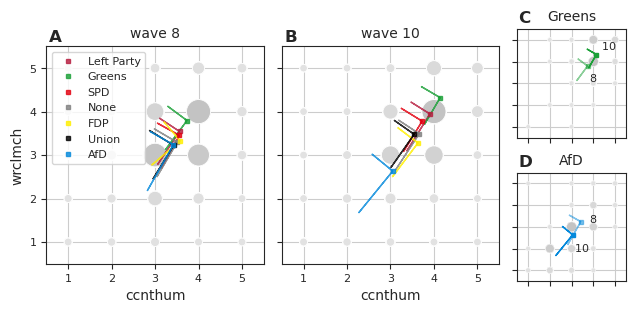

In [13]:
scale = 1
cmap = truncate_colormap(plt.get_cmap("Greys"), 0.2, 0.35)

fig, axs = plt.subplot_mosaic([["a", "b", "Greens"], ["a" ,"b", "AfD"]], gridspec_kw={"width_ratios":[1,1,0.5]}, sharey=True, figsize=(16/2.54,8/2.54))#figsize=(16/2.54,8/2.54))

for r, ax in zip(waves, [axs["a"], axs["b"]]):
    #ax.set_facecolor("snow")
    df =  filtered_data.loc[filtered_data.essround==r][["ccnthum", "wrclmch"]].dropna(how="any")
    counts = df.groupby(['wrclmch', 'ccnthum']).size()
    df['observation_count'] = df.groupby(['wrclmch', 'ccnthum']).transform('size')
    sns.scatterplot(
        x='ccnthum',
        y='wrclmch',
        hue='observation_count',
        palette=cmap,  # Blues and oranges color palette
        size='observation_count',
        sizes=(30, 300),  # Adjust size range
        data=df,
        ax = ax, 
        legend=False
    )
    for p in parties:
        #if not p=="None":
        #    pass
        #else:
        col = cols[p]      
        
        X_train = filtered_data.loc[filtered_data.essround==r].loc[filtered_data.identity==p][["ccnthum", "wrclmch"]].dropna(how="any").to_numpy()
        ax.plot(X_train[:,0].mean(), X_train[:,1].mean(), color=col, ls="", marker="s", markersize=3 , alpha=0.8, label=p)
        for i in range(2):
            vec = CSS_dict[r][p][:, i] * scale
            if (r==waves[0]) and (i==0) and (p=="FDP"):
                vec=-vec
            dx = vec[0] 
            dy = vec[1] 
            ax.arrow(X_train[:,0].mean(), X_train[:,1].mean(), dx, dy,color=cols[p], lw=1, alpha=0.8)
            
        if (r==waves[1]) and (p=="AfD" or p=="Greens"):
            df =  filtered_data.loc[filtered_data.essround==r].loc[filtered_data.identity==p][["ccnthum", "wrclmch"]].dropna(how="any")
            df['observation_count'] = df.groupby(['wrclmch', 'ccnthum']).transform('size')
            sns.scatterplot(x='ccnthum',y='wrclmch', hue='observation_count', palette=cmap, size='observation_count', sizes=(10, 50), data=df, alpha=1, ax = axs[p], legend=False)
            col = cols[p]
            for r2, alpha in zip(waves, [0.5, 1]):
                X_train = filtered_data.loc[filtered_data.essround==r2].loc[filtered_data.identity==p][["ccnthum", "wrclmch"]].dropna(how="any").to_numpy()
                axs[p].plot(X_train[:,0].mean(), X_train[:,1].mean(), color=col, ls="", marker="s", markersize=3 , alpha=alpha)
                for i in range(2):
                    vec = CSS_dict[r2][p][:, i] * scale
                    dx = vec[0] 
                    dy = vec[1] 
                    axs[p].arrow(X_train[:,0].mean(), X_train[:,1].mean(), dx, dy,color=cols[p], lw=1, alpha=alpha)
            axs[p].set_xlabel("")
            axs[p].set_ylabel("")
            #axs[p].legend(title="wave", fontsize=smallfs)
            axs[p].set_ylim(0.5, 5.5)
            axs[p].set_xlim(0.5, 5.5)
            axs[p].set_xticks(range(1,6))
            axs[p].set_yticks(range(1,6))
            axs[p].set_aspect("equal")
            axs[p].grid(True)
            axs[p].set_title(p, fontsize=bigfs)
            axs[p].set_xticklabels(["" for _ in axs[p].get_xticklabels()])

            
    ax.set_ylim(0.5, 5.5)
    ax.set_xlim(0.5, 5.5)
    ax.set_xticks(range(1,6))
    ax.set_yticks(range(1,6))
    ax.set_aspect("equal")
    ax.grid(True)
    ax.set_xlabel("ccnthum", fontsize=bigfs)
    if r==waves[0]:
        ax.set_ylabel("wrclmch", fontsize=bigfs)
    ax.set_title(f"wave {r}", fontsize=bigfs)
axs["a"].legend(fontsize=smallfs)


axs["Greens"].text(4.34, 4.45, r"$10$", ha="left", va="bottom", fontsize=smallfs)
axs["Greens"].text(3.8,3, r"$8$", ha="left", va="bottom", fontsize=smallfs)

axs["AfD"].text(3.8, 3.1, r"$8$", ha="left", va="bottom", fontsize=smallfs)
axs["AfD"].text(3.1, 2.3, r"$10$", ha="left", va="top", fontsize=smallfs)



axs["a"].text(0.01, 1.01, "A", va="bottom", ha="left", fontdict={"weight":"bold", "size":12}, transform=axs["a"].transAxes)
axs["b"].text(0.01, 1.01, "B", va="bottom", ha="left", fontdict={"weight":"bold", "size":12}, transform=axs["b"].transAxes)
axs["Greens"].text(0.01, 1.03, "C", va="bottom", ha="left", fontdict={"weight":"bold", "size":12}, transform=axs["Greens"].transAxes)
axs["AfD"].text(0.01, 1.03, "D", va="bottom", ha="left", fontdict={"weight":"bold", "size":12}, transform=axs["AfD"].transAxes)
fig.subplots_adjust(left=0.07, right=0.99, top=0.96, bottom=0.07, wspace=0.1, hspace=0.05)

#fig.set_facecolor("y")
#fig.tight_layout()
#plt.savefig("figs/Trafo_8-10_clch_party_onlyBlobsTot.png", dpi=600)
plt.savefig(f"figs/Trafo_{waves[0]}-{waves[1]}_clch_party_+density_withId_withExamples.png", dpi=600)
plt.savefig(f"figs/Trafo_{waves[0]}-{waves[1]}_clch_party_+density_withId_withExamples.pdf")
    

### Length of axes

In [14]:
print("Length of the axes of Greens:")
for w in waves: 
    print(f"wave {w}: ", end="")
    for v in range(2):
        print(f"vec {v}-->{np.linalg.norm(CSS_dict[w]['Greens'][:, v]):.2f}", end=", ")
    print("")

print("Length of the axes of AfD:")
for w in waves: 
    print(f"wave {w}: ", end="")
    for v in range(2):
        print(f"vec {v}-->{np.linalg.norm(CSS_dict[w]['AfD'][:, v]):.2f}", end=", ")
    print("")

Length of the axes of Greens:
wave 8: vec 0-->0.55, vec 1-->0.84, 
wave 10: vec 0-->0.50, vec 1-->0.71, 
Length of the axes of AfD:
wave 8: vec 0-->0.61, vec 1-->1.21, 
wave 10: vec 0-->0.61, vec 1-->1.23, 


# Opinion distribution as seen by Greens

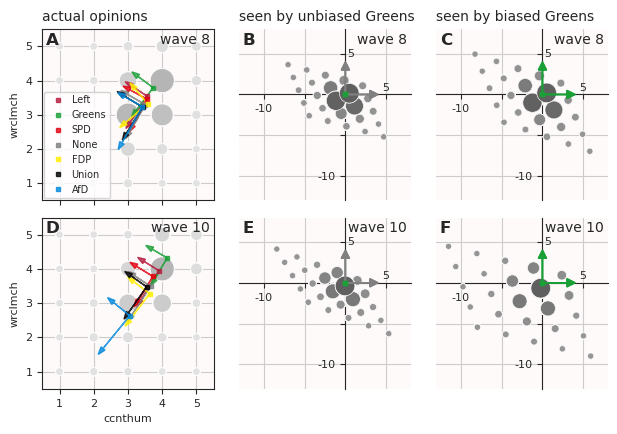

In [147]:
fig, axs = plt.subplots(2,3, figsize=(16/2.54, 11/2.54), gridspec_kw={"width_ratios":[1,1,1]})#, sharex=True, sharey=True)
p = "Greens"
#fig.suptitle("Opinion distribution seen by "+p, fontsize=bigfs)
cmapG = truncate_colormap(plt.get_cmap("Greys"), 0.5, 0.7)
#TrafosUsed = [
#    {8: np.diag(np.ones(2)), 10: np.diag(np.ones(2))}, 
#    {8: Trafo[8]["None"], 10: Trafo[10]["None"]}, 
#    {8: Trafo[8][p], 10: Trafo[10][p]}
#]
titles = [r"seen by unbiased Greens", r"seen by biased Greens"]
for col, wgroup, title in zip([1,2], ["None", p], titles):
    axsCol = axs[:, col]
    for r, ax in zip(waves, axsCol):
        Tr = Trafo[r][wgroup]
        MeanGreen = filtered_data.loc[filtered_data.essround==r].loc[filtered_data.identity=="Greens"][["ccnthum", "wrclmch"]].dropna(how="any").to_numpy().mean(axis=0)
        df = filtered_data.loc[filtered_data.essround==r][["ccnthum", "wrclmch"]].dropna(how="any") - MeanGreen
        df = pd.DataFrame(np.dot(df, Tr), columns=["ax1", "ax2"])
        ax.set_facecolor("snow")

        #counts = df.groupby(['ax1', 'ax2']).size()
        df['observation_count'] = df.groupby(['ax1', 'ax2']).transform('size')
        sns.scatterplot(
            x='ax1',
            y='ax2',
            hue='observation_count',
            palette=cmapG,  # Blues and oranges color palette
            size='observation_count',
            sizes=(20, 200),  # Adjust size range
            data=df,
            ax = ax, 
            legend=False, 
            zorder=10
        )
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_ylim(-13, 8)
        ax.set_xlim(-13, 8)
        ax.set_xticks([-10, -5,0,5,])
        ax.set_yticks([-10,-5, 0, 5,])
        ax.set_xticklabels(["-10","", "",""])
        ax.set_yticklabels(["-10","","",""])
        ax.set_aspect("equal")
        ax.grid(True, zorder=0)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines['left'].set_position('zero')
        ax.spines['bottom'].set_position('zero')
        ax.text(0.2,5, r"5", fontsize=smallfs, ha="left", va="center", )
        ax.text(5, 0.2, r"5", fontsize=smallfs, ha="center", va="bottom", )
        for sp in ax.spines:
            ax.spines[sp].set(zorder=1)
        ax.set_aspect("equal")
        for ax in axs[:, col]:
            ax.arrow(0, 0, 0,3,color=cols[wgroup], lw=1, alpha=1, zorder=15, width=0.002, head_width=1, head_length=1)
            ax.arrow(0, 0, 3,0,color=cols[wgroup], lw=1, alpha=1, zorder=15, width=0.002, head_width=1, head_length=1)
            ax.scatter([0],[0], marker="s", s=5, color=cols[p] ,zorder=16)

    axsCol[0].set_title(title, fontsize=bigfs, ha="left", x=0)

axsCol = axs[:, 0]
cmap = truncate_colormap(plt.get_cmap("Greys"), 0.2, 0.4)
for r, ax in zip(waves, axsCol):
    ax.set_facecolor("snow")
    df =  filtered_data.loc[filtered_data.essround==r][["ccnthum", "wrclmch"]].dropna(how="any")
    counts = df.groupby(['wrclmch', 'ccnthum']).size()
    df['observation_count'] = df.groupby(['wrclmch', 'ccnthum']).transform('size')
    sns.scatterplot(
        x='ccnthum',
        y='wrclmch',
        hue='observation_count',
        palette=cmap,  # Blues and oranges color palette
        size='observation_count',
        sizes=(30, 300),  # Adjust size range
        data=df,
        ax = ax, 
        legend=False
    )
    for p in parties:
        #if not p=="None":
        #    pass
        #else:
        #col = cols[p]      
        
        X_train = filtered_data.loc[filtered_data.essround==r].loc[filtered_data.identity==p][["ccnthum", "wrclmch"]].dropna(how="any").to_numpy()
        ax.plot(X_train[:,0].mean(), X_train[:,1].mean(), color=cols[p], ls="", marker="s", markersize=3 , alpha=0.8, label="Left" if p=="Left Party" else p)
        scale=1
        for i in range(2):
            vec = CSS_dict[r][p][:, i] * scale
            if (r==waves[0]) and (i==0) and (p=="FDP"):
                vec=-vec
            dx = vec[0] 
            dy = vec[1] 
            ax.arrow(X_train[:,0].mean(), X_train[:,1].mean(), dx, dy,color=cols[p], alpha=0.8, label="", width=0.001, head_width=0.15)


    ax.set_ylim(0.5,5.5)
    ax.set_xlim(0.5,5.5)
    ax.set_xticks(range(1,6))
    ax.set_yticks(range(1,6))
    ax.set_ylabel(ax.get_ylabel(), fontsize=smallfs)#, y=0.1, ha="left")

    if r==10:
        ax.set_xticklabels(["1", "2", "3", "4", "5"], fontsize=smallfs)
        ax.set_xlabel(ax.get_xlabel(), fontsize=smallfs)# x=0.1, ha="left")
    else:
        ax.set_xticklabels([])
        ax.set_xlabel("")
    ax.set_yticklabels(["1", "2", "3", "4", "5"], fontsize=smallfs)
    
    ax.set_aspect("equal")
    ax.grid(True, zorder=0)
    #ax.spines["top"].set_visible(False)
    #ax.spines["right"].set_visible(False)
    #ax.spines['left'].set_position('zero')
    #ax.spines['bottom'].set_position('')
    for sp in ax.spines:
        ax.spines[sp].set(zorder=1)
    ax.set_aspect("equal")    
    
axsCol[0].legend(fontsize=smallfs-1, handletextpad=0.4, borderaxespad=0.2, loc="lower left")
axsCol[0].set_title(r"actual opinions", fontsize=bigfs, ha="left", x=0)
   
#for ax, r in zip(axs[:,0], [8,10]):
#    for sp in ax.spines:
#        ax.spines[sp].set_visible(False)
#    ax.set_xticks([])
#    ax.set_yticks([])
#    ax.text(0.,1, rf"wave {r}", ha="left", va="top", fontsize=12, rotation=90, transform=ax.transAxes)
for row, r in enumerate([8,10]):
    for ax in axs[row,:]:
        ax.text(0.98,0.98, rf"wave {r}", ha="right", va="top", fontsize=bigfs, transform=ax.transAxes)

letters = ["A", "B", "C", "D", "E", "F"]
for l, ax in enumerate(axs[:,].flatten()):
    ax.text(0.02, 0.98, letters[l], va="top", ha="left", fontdict={"weight":"bold", "size":12}, transform=ax.transAxes, zorder=20)

#fig.subplots_adjust(left=0.0, right=0.99, top=0.93, bottom=0.1, wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.08, right=0.99, top=0.93, bottom=0.1, wspace=0.1, hspace=0.1)
#fig.set_facecolor("pink")
plt.savefig("figs/opinionDist_seen_by_greens.pdf")
plt.savefig("figs/opinionDist_seen_by_greens.png", dpi=600)

